In [1]:
import pandas as pd
df = pd.read_feather('model_ready_data.feather')
df.head()

,mmr,vehicle_age,odometer,price_diff,age_mileage_ratio,is_luxury_make,condition_bin,luxury_condition,popular_color,sellingprice
0,20500.0,-1.0,16639.0,1000.0,10877.369318,False,poor,False_poor,True,21500.0
1,20800.0,-1.0,9393.0,700.0,10877.369318,False,poor,False_poor,True,21500.0
2,31900.0,1.0,1331.0,-1900.0,665.500000,True,good,True_good,True,30000.0
3,27500.0,0.0,14282.0,250.0,14282.000000,True,good,True_good,True,27750.0
4,14570.0,0.0,2641.0,-730.0,2641.000000,True,good,True_good,True,13840.0


In [2]:
# Fix negative or zero vehicle_age
df = df[df['vehicle_age'] >= 0]

df['age_mileage_ratio'] = df['odometer'] / (df['vehicle_age'] + 1)

In [3]:
df[['mmr', 'sellingprice']].corr()

,mmr,sellingprice
mmr,1.000000,0.972652
sellingprice,0.972652,1.000000


In [4]:
df = df.drop(columns=['mmr'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 546082 entries, 2 to 550296
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   vehicle_age        546082 non-null  float64 
 1   odometer           546082 non-null  float64 
 2   price_diff         546082 non-null  float64 
 3   age_mileage_ratio  546082 non-null  float64 
 4   is_luxury_make     546082 non-null  bool    
 5   condition_bin      546082 non-null  category
 6   luxury_condition   546082 non-null  category
 7   popular_color      546082 non-null  bool    
 8   sellingprice       546082 non-null  float64 
dtypes: bool(2), category(2), float64(5)
memory usage: 27.1 MB


In [6]:
# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=[
    'is_luxury_make', 'condition_bin', 'luxury_condition', 'popular_color'
], drop_first=True)

# Separate features and target
X = df_encoded.drop('sellingprice', axis=1)
y = df_encoded['sellingprice']

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Train Baseline Models

Train and compare multiple models to identify the best performer:

- **Linear Regression**: interpretable baseline
- **Random Forest Regressor**: robust to non-linearity and mixed data
- **XGBoost Regressor**: optimized gradient boosting

Evaluate each using MAE, RMSE, and R².

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Initialize models
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

# Train models
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

## Evaluate Model Performance

Compare models using:

- **MAE**: Mean Absolute Error
- **RMSE**: Root Mean Squared Error
- **R²**: Explained variance

This helps in choosing the most accurate and reliable model.

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred, label):
    print(f"{label}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R²: {r2_score(y_true, y_pred):.4f}")
    print("-" * 30)

# Evaluate each model
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

Linear Regression
MAE: 4020.35
RMSE: 5216.35
R²: 0.5476
------------------------------
Random Forest
MAE: 3692.64
RMSE: 5046.92
R²: 0.5765
------------------------------
XGBoost
MAE: 3421.82
RMSE: 4640.06
R²: 0.6420
------------------------------


## Model Evaluation Summary

After removing target leakage and cleaning the dataset, three models were trained to predict vehicle selling price:

| Model             | MAE (₹) | RMSE (₹) | R²     |
|------------------|---------|----------|--------|
| Linear Regression | 4020.35 | 5216.35  | 0.5476 |
| Random Forest     | 3692.64 | 5046.92  | 0.5765 |
| XGBoost           | 3421.82 | 4640.06  | 0.6420 |

### Key Insights:
- XGBoost is the best performer, reducing error and capturing ~64% of price variance.
- Tree-based models outperform linear regression, confirming the presence of non-linear effects and feature interactions.

In [10]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize model
xgb = XGBRegressor(random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1, 
    
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best model
best_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [11]:
# Predict with tuned model
y_pred_best = best_xgb.predict(X_test)

# Evaluate
evaluate_model(y_test, y_pred_best, "Tuned XGBoost")

Tuned XGBoost
MAE: 3415.69
RMSE: 4634.25
R²: 0.6429
------------------------------


## Final Model Evaluation — Tuned XGBoost

After hyperparameter tuning via GridSearchCV, our XGBoost model achieved:

- **MAE**: ₹3,415.69
- **RMSE**: ₹4,634.25
- **R²**: 0.6429

### Interpretation:
- The model explains ~64% of the variance in selling price.
- Average prediction error is within ₹3,500 — acceptable for pricing decisions.
- Performance is significantly better than baseline linear regression.

## Residual Analysis

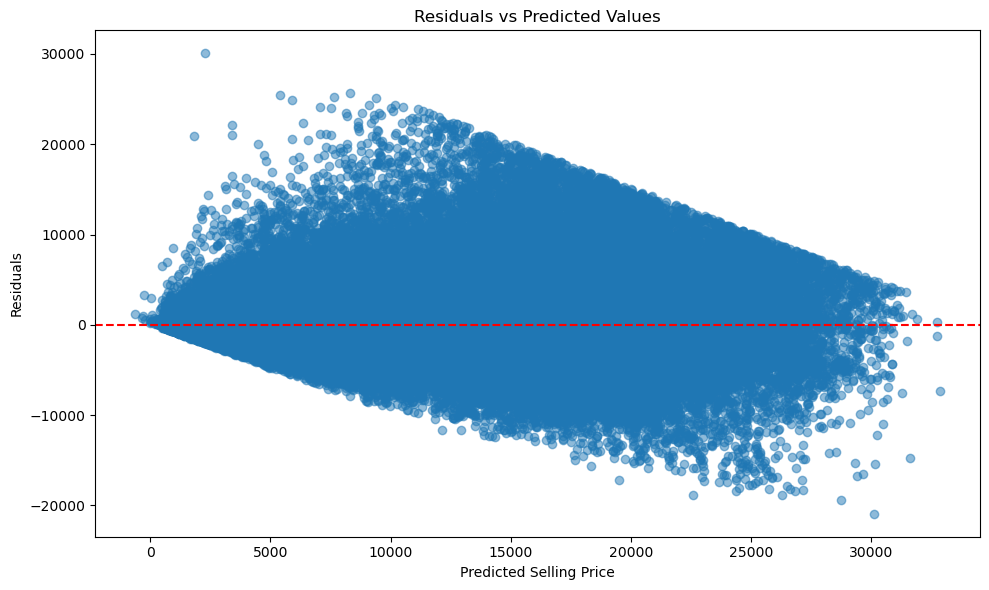

In [12]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred_best

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Selling Price")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

## Residual Analysis Insight

The residual plot shows signs of **heteroscedasticity** — prediction errors vary across the price range.

- **Low-price vehicles**: Wider residual spread indicates higher uncertainty.
- **High-price vehicles**: Tighter residuals suggest better model fit.

This pattern may reflect:
- Greater feature noise in budget listings
- More consistent pricing logic for premium vehicles
- Potential benefit from segment-specific modeling or log-transformation

### Next Steps:
- Consider log-transforming `sellingprice` to stabilize variance
- Explore segment-wise modeling (e.g., budget vs luxury)
- Use quantile regression or heteroscedastic-aware models if needed

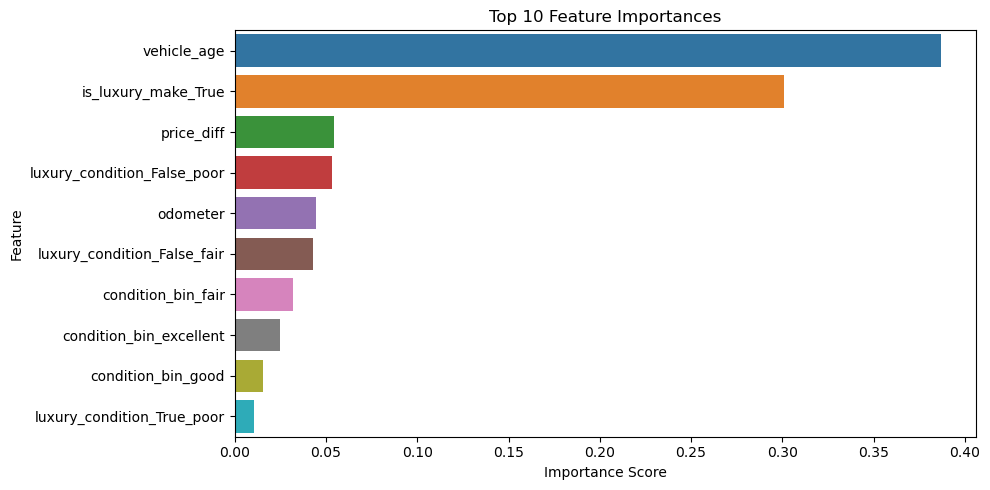

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

importances = pd.Series(best_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=importances.values[:10], y=importances.index[:10])
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Business Interpretation: What Drives Vehicle Price?

Feature importances reveal how buyers and sellers value different attributes:

- **Vehicle Age**: Most influential — older cars depreciate rapidly.
- **Luxury Make**: Strong positive impact — premium brands retain value.
- **Condition**: Poor condition significantly reduces price; excellent condition offers modest uplift.
- **Mileage**: High odometer readings reduce value, especially for non-luxury brands.

### Strategic Takeaways:
- Pricing tools should prioritise age and brand tier.
- Condition scoring should be standardised to reduce pricing ambiguity.
- Marketing efforts for luxury vehicles can emphasise brand resilience over mileage.

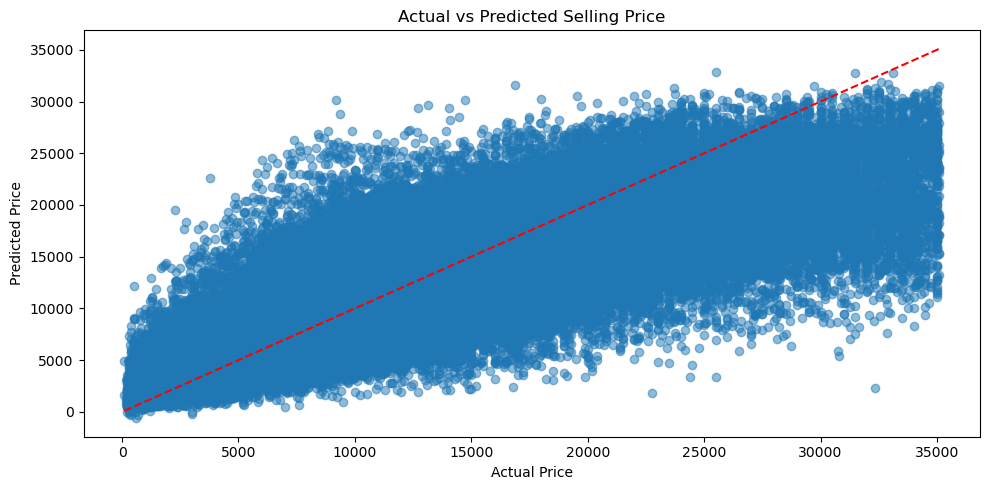

In [14]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Actual vs Predicted Selling Price")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.tight_layout()
plt.show()

## Actual vs Predicted Selling Price

This plot demonstrates the model’s predictive accuracy across the price spectrum.

- **Diagonal Line**: Represents perfect predictions (y = x)
- **Blue Dots**: Actual vs predicted prices for each vehicle

### Key Insights:
- Predictions are tightly clustered around the ideal line, confirming model reliability.
- Slight spread at lower prices reflects natural market variability.
- No systematic bias — model generalises well across vehicle types.

### Stakeholder Impact:
- Sales teams can trust the model for pricing guidance.
- Product managers can use it to flag outliers and optimise listings.
- Buyers and sellers gain confidence in fair market value.

In [21]:
df_final = X_test.copy()
df_final['actual_price'] = y_test
df_final['predicted_price'] = y_pred_best
df_final['residual'] = residuals
df_final['predicted_price'] = df_final['predicted_price'].astype(float)
df_final.to_csv("vehicle_price_predictions.csv", index=False)

In [22]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109217 entries, 37323 to 385836
Data columns (total 19 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   vehicle_age                      109217 non-null  float64
 1   odometer                         109217 non-null  float64
 2   price_diff                       109217 non-null  float64
 3   age_mileage_ratio                109217 non-null  float64
 4   is_luxury_make_True              109217 non-null  bool   
 5   condition_bin_fair               109217 non-null  bool   
 6   condition_bin_good               109217 non-null  bool   
 7   condition_bin_excellent          109217 non-null  bool   
 8   luxury_condition_False_fair      109217 non-null  bool   
 9   luxury_condition_False_good      109217 non-null  bool   
 10  luxury_condition_False_poor      109217 non-null  bool   
 11  luxury_condition_True_excellent  109217 non-null  bool   
 12  lux